In [4]:
import numpy as np
from scipy.stats import norm
import numpy.matlib
from scipy.stats import uniform
import matplotlib.pyplot as plt
import random
from scipy import stats

In [2]:
#Market Information as per the data 
risk_free = 0.08

#Share Specific Information 
S_0 = 100
sigma = 0.3

#Up and Out Call option specific information
strike = 100
T = 1
barrier = 150

#Firm Specific Information for pricing 
# we are Assuming Initial value of the Firm as = 200
V_0 = 200
sigma_firm = 0.25
debt = 175
recovery_rate = 0.25
correlation = 0.2

#Simulation specific information
#Monthly Simulation for the lifetime of the option 
n_steps = 12


In [6]:
#Question 4: Regular call option price
def bs_call(S0,K,T,r,vol):
    """
       Returns: Call value under Black-Schole-Merton option model
    """    
    d1=(np.log(S0/K)+(r+vol**2/2)*T)/(vol*np.sqrt(T))
    d2 = d1-vol*np.sqrt(T)
    return S0*stats.norm.cdf(d1)-K*np.exp(-r*T)*stats.norm.cdf(d2)

# result:
print("The Vanilla European call price is : " + str(round(bs_call(S_0,strike,T,risk_free,sigma),3)))

The Vanilla European call price is : 15.711


In [12]:
#Question 5: Up and out call option price
#Analytical solution for vanilla call option
def bs_call1(S,X):
    """
       Returns: Call value under Black-Schole-Merton option model
       Format   : bs_call(S,X,T,r,sigma)
               S: current stock price
               X: exercise price
               T: maturity date in years
              rf: risk-free rate (continusouly compounded)
           sigma: volatiity of underlying security 
    """    
    d1=(np.log(S/X)+(risk_free+sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1-sigma*np.sqrt(T)
    return S*stats.norm.cdf(d1)-X*np.exp(-risk_free*T)*stats.norm.cdf(d2)

def d2(S, X):
    return (np.log(S/X)+(risk_free-sigma**2/2)*T)/(sigma*np.sqrt(T))

#Analytical solution for up and out call option
def analytical_up_and_out_call(S_0, strike, barrier, risk_free, T):
    return bs_call1(S_0, strike) - bs_call1(S_0, barrier) - (barrier - strike)*np.exp(-risk_free*T)*stats.norm.cdf(d2(S_0, barrier))-((barrier/S_0)**(2*(risk_free - sigma**2/2)/sigma**2))*(bs_call1((barrier**2/S_0), strike) - bs_call1((barrier**2/S_0), barrier)- (barrier - strike)*np.exp(-risk_free*T)*stats.norm.cdf(d2(barrier, S_0)))

analytical_up_and_out_call(S_0, strike, barrier, risk_free, T)

5.312942876953661

In [267]:
#Function for both terminal value for stock and firm
def terminal_value(S_0, risk_free, sigma, Z, T):
    return S_0*np.exp(np.cumsum((risk_free - sigma**2/2)*T + sigma*np.sqrt(T)*Z))

#Function for calculating vanilla call option payoff
def call_payoff(S_T, K, risk_free, T):
    return np.exp(-risk_free*T)*np.maximum(S_T-K, 0)

In [1]:
#Function for calculating default free up and out call option's price
def up_and_out_call(S_0, strike, T, r, sigma, n_simulation, n_steps, barrier, corr_norm_matrix):
    dt=T/n_steps
    total = 0
    S_t = [None]*n_steps
    for j in range(0,n_simulation):
        S_t = S_0
        out = 0
        Z = corr_norm_matrix[j:j+n_steps]
        S_t = terminal_value(S_0, r, sigma, Z, dt)
        if np.max(S_t) > barrier:
            out = True
        if out==False:
            total+= call_payoff(S_t[n_steps-1], strike, r, T)
    return total/n_simulation

#Function for calculating terminal firm values from firm values path
def firm_val(V_0, T, r, sigma_firm, n_simulation, n_steps, corr_norm_matrix):   
    dt=T/n_steps
    firm_term_array = [None]*n_simulation
    for k in range(0, n_simulation):
        Z = corr_norm_matrix[k:k+n_steps]
        firm_path = terminal_value(V_0, r, sigma_firm, Z, dt)
        firm_term_array[k] = firm_path[n_steps-1]
    return firm_term_array

In [273]:
#Question 8
'''Creating arrays for storing cva,price of default free up and out call option and price of price of option incorporating 
counterparty default risk values'''
cva_estimate = [None]*50
up_and_out_call_estimate = [None]*50
up_and_out_call_std = [None]*50
default_up_and_out_call_estimate = [None]*50

for i in range(1,51):
    #Generating multivariate normal distributed samples for paths of stock and firm values
    n_simulation = i*1000
    corr_matrix = np.array([[1, correlation],[correlation, 1]])
    norm_matrix = norm.rvs(size = np.array([2,i*1000*n_steps]))
    corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_matrix), norm_matrix)
    
    #Estimating default free price of up and out call option
    value = up_and_out_call(S_0, strike, T, risk_free, sigma, n_simulation, n_steps, barrier, corr_norm_matrix[0,])  
    up_and_out_call_estimate[i-1] = np.mean(value)
    up_and_out_call_std[i-1] = np.std(value)/np.sqrt(1000*i)
    
    #Estimating CVA
    term_firm_val = np.array(firm_val(V_0, T, risk_free, sigma_firm, n_simulation, n_steps, corr_norm_matrix[1,]))   
    amount_lost = np.exp(-risk_free*T)*(1-recovery_rate)*(term_firm_val < debt)*up_and_out_call_estimate[i-1]
    cva_estimate[i-1] = np.mean(amount_lost)
    
    #Estimating price of option incorporating counterparty risk
    default_up_and_out_call_estimate[i-1] = up_and_out_call_estimate[i-1] - cva_estimate[i-1]

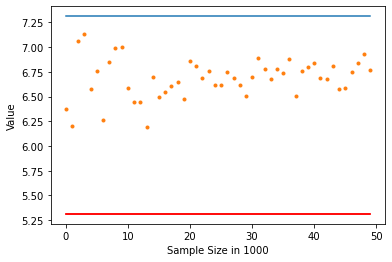

In [275]:
#Plotting default free price of option and analytical solution
analytical_price = analytical_up_and_out_call(S_0, strike, barrier, risk_free, T)
plt.plot([analytical_price+2]*50)
plt.plot(up_and_out_call_estimate, '.')
plt.plot(analytical_price + 3*np.array(up_and_out_call_std),'r')
plt.plot(analytical_price - 3*np.array(up_and_out_call_std),'r')
plt.xlabel("Sample Size in 1000")
plt.ylabel("Value")
plt.show()

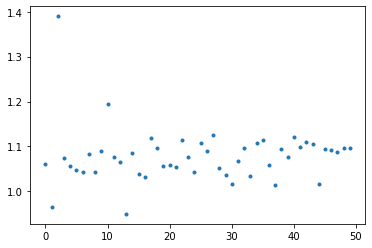

In [276]:
#Plotting CVA
plt.plot(cva_estimate, '.')
plt.show()

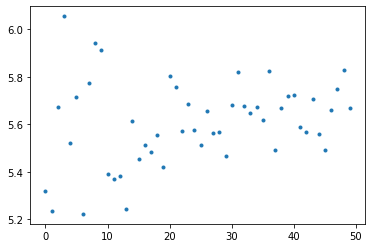

In [277]:
#Question 9
#Plotting price of option with counterparty risk
plt.plot(default_up_and_out_call_estimate, '.')
plt.show()